In [14]:
from wind_ae.wrapper.relax_wrapper import wind_simulation as wind_sim
from wind_ae.wrapper.wrapper_utils.plots import energy_plot, six_panel_plot, quick_plot 
from wind_ae.wrapper.wrapper_utils import constants as const
from wind_ae.wrapper.wrapper_utils.system import system
from wind_ae.wrapper.wrapper_utils.spectrum import spectrum
import wind_ae.McAstro.atoms.atomic_species as McAtom
import matplotlib.ticker as ticker
from wind_ae.wrapper.wrapper_utils.plots import _custom_rc_params

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.units as u
import astropy.constants as c
from p_winds import tools, parker, hydrogen, helium, transit, lines

## ATES: Instructions and inputs
If you want to run ATES yourself:
https://github.com/AndreaCaldiroli/ATES-Code 
1. `./run_ATES.sh`
2. Modify parameters in the gui (keep Reconstruction on PLM)
3. Click start
4. Stop manually when the residual is < 0.5-1
5. `./run_ATES.sh`
6. In the gui, click the box that says load IC. Switch reconstruction to WENO3.
7. Start.

In [15]:
#ATES matching
sim = wind_sim()
sim.load_planet('data/HD209_13.6-2000eV_H-He.csv',print_atmo=False)
print('log(n0)',np.log10(sim.windsoln.soln['n_HI'][0]+sim.windsoln.soln['n_HeI'][0]))
print('Teq',sim.windsoln.T_rmin*1e4)
print('H/He num ratio',sim.windsoln.soln['n_He'][0]/sim.windsoln.soln['n_H'][0])
E = sim.windsoln.E_wl
flux_bin = sim.windsoln.wPhi_wl*sim.windsoln.Ftot*E
print("X-ray lum", np.log10(sum(flux_bin[(E>124*const.eV)])*4*np.pi*sim.windsoln.semimajor**2))
print("EUV lum", np.log10(sum(flux_bin[(E<124*const.eV)])*4*np.pi*sim.windsoln.semimajor**2))

log(n0) 13.035584012633581
Teq 1534.820918516
H/He num ratio 0.06293436895432543
X-ray lum 26.88507574809146
EUV lum 27.837780927165937


In [ ]:
ates = np.genfromtxt('data/ATES_Hydro_ioniz.txt',
                     names=['r','rho','v','P','T','heating','eff'])
ates_ion = np.genfromtxt('data/ATES_Ion_species.txt',
                         names=['r','n_HI','n_HII','n_HeI','n_HeII'])

## p-winds: Inputs
https://github.com/ladsantos/p-winds

Modify all instances of scipy's trapz, cumtrapz, and simps or roll back Python version number to run

In [3]:
sim=wind_sim()
sim.load_planet('data/HD209_13.6-2000eV_H-He.csv', print_atmo=False)
print("log(Mdot):",np.log10(sim.windsoln.Mdot))
print('H/He num ratio:',sim.windsoln.soln['n_H'][0]/sim.windsoln.soln['n_tot'][0])
__,__,__,idx = sim.erf_velocity(return_idx=True)
print("T at base of wind: %.0f K" % np.mean(sim.windsoln.soln['T'][idx:]))
print("Max T in wind: %.0f (note: p-winds won't solve for this high of a temp)" % np.max(sim.windsoln.soln['T']))

log(Mdot): 10.308113943105692
H/He num ratio: 0.9407918580935173
T at base of wind: 3583 K
Max T in wind: 8617 (note: p-winds won't solve for this high of a temp)


#### If you want to run p-winds yourself, run commented cell below 
#### Otherwise, just load solution in cell below

In [ ]:
r, rho_plot, v_plot,f_ion = np.loadtxt('data/p-winds_solution.txt', unpack=True)

In [ ]:
# units = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
# spectrum = tools.make_spectrum_from_file('data/p-winds_solar_spectrum_scaled_lambda.dat', units)
# # HD 209458 b planetary parameters, measured
# R_pl = 1.39  # Planetary radius in Jupiter radii
# M_pl = 0.73  # Planetary mass in Jupiter masses
# impact_parameter = 0.499  # Transit impact parameter

# # A few assumptions about the planet's atmosphere
# m_dot = 1.57e10  # Total atmospheric escape rate in g / s
# T_0 = 8616  # Wind temperature in K
# h_fraction = 0.94  # H number fraction
# he_fraction = 1 - h_fraction  # He number fraction
# he_h_fraction = he_fraction / h_fraction
# mean_f_ion = 0.0  # Mean ionization fraction (will be self-consistently calculated later)
# mu_0 = (1 + 4 * he_h_fraction) / (1 + he_h_fraction + mean_f_ion)  
# # mu_0 is the constant mean molecular weight (assumed for now, will be updated later)

# initial_f_ion = 0.0
# r = np.logspace(0, np.log10(20), 100)  # Radial distance profile in unit of planetary radii

# f_r, mu_bar,rates = hydrogen.ion_fraction(r, R_pl, T_0, h_fraction, 
#                             m_dot, M_pl, mu_0,
#                             spectrum_at_planet=spectrum, exact_phi=True,
#                             initial_f_ion=initial_f_ion, relax_solution=True,
#                             return_mu=True, return_rates=True)
# f_ion = f_r
# f_neutral = 1 - f_r

# # plt.plot(r, f_neutral, color='C0', label='f$_\mathrm{neutral}$')

# vs = parker.sound_speed(T_0, mu_bar)  # Speed of sound (km/s, assumed to be constant)
# rs = parker.radius_sonic_point(M_pl, vs)  # Radius at the sonic point (jupiterRad)
# rhos = parker.density_sonic_point(m_dot, rs, vs)  # Density at the sonic point (g/cm^3)

# r_array = r * R_pl / rs
# v_array, rho_array = parker.structure(r_array)

# # Convenience arrays for the plots
# r_plot = r_array * rs / R_pl
# v_plot = v_array * vs
# rho_plot = rho_array * rhos

## Plotting the comparison

In [21]:
def quick_plot(soln, Mdot_legend=True, line_color='k', line_style='-', line_label='',label_dim=[0,1.3,2],
             ion_label=True,first_plotted=True, ax=0,shortlabel='',fontsize=12): 
    '''
    Description: 
        Plots density (g/cm3), temperature (K), velocity (10 km/s), 
        ionization fraction as a function of r (Rp).
        
    Arguments:
        soln - windsoln object (sim.windsoln)
        Mdot_legend - Bool; if True, put Mdot in legend of plot. Else, just prints.
        line_color - str; line color 
        line_style - str; line style
        label_dim - list; default=[0,1.3,2]. Location of label and ncols [x,y,ncols]. 
        first_plotted - Bool; True if this the first of many Four plots 
                        to be plotted on the same axes. 
    Returns:
        ax - axes object (if first_plotted=True)
        title
    '''
    try: # Check if R_cori has be calculated. If not, calculate all post-facto user variables
        soln.R_cori
    except AttributeError:
        if soln.integrate_outward == 0:
            soln.R_cori = 1e10
        else:
            soln.add_user_vars()
    
    radius_norm = 1.0
    alpha=0.5
    radius = soln.soln_norm['r']
    R_H = soln.semimajor*(soln.Mp/(3*soln.Mstar))**(1/3) / soln.Rp
    nspecies = soln.nspecies
    
    colormap,custom_cycler,fontsize,columns = _custom_rc_params(line_color,nspecies)
    ss=15
    
    stack=2
    fig, ax = plt.subplots(stack,2,sharex=True,figsize=[11,6])
    fig.subplots_adjust(hspace=0)

    #Density (+Hill Radius and sonic point for legend purposes)
    ax[0,0].semilogy(soln.soln_norm['r'], soln.soln['rho'], c=line_color,ls=line_style,label='Wind-AE')
    ax[0,0].semilogy(r,rho_plot, c='tab:orange',label='p-winds')
    ax[0,0].semilogy(ates['r'],ates['rho']*const.mH, c='tab:blue',label='ATES')
    
    ax[0,0].axvline(radius_norm*(soln.soln_norm['z'][1]+1.),c=line_color, alpha=alpha, ls='--', zorder=3,label='Sonic Point')
    ax[0,0].axvline(rs*const.Rjupiter/sim.windsoln.Rp,ls='--',c='tab:orange')
    ax[0,0].axvline(max(ates['r']),ls='--',c='tab:blue')
    ax[0,0].axvline(R_H,ls=':',c=line_color,label='Hill Radius')
 
    ax[0,0].set_ylabel(r'Density (g/cm$^3$)',fontsize=ss)
    ax[0,0].legend(fontsize=fontsize)
 
    #Velocity 
    ax[1,0].plot(soln.soln_norm['r'], soln.soln['v']/1e6, c=line_color,ls=line_style)
    ax[1,0].plot(r,v_plot*1e5/1e6, c='tab:orange')
    ax[1,0].plot(ates['r'],ates['v']/1e6)
    ax[1,0].set_ylim(top=2)
    ax[1,0].set_ylabel(r'Velocity (10 km/s)',fontsize=ss)
    
    #Temperature
    mdot = (soln.Mdot)#/const.Msun)*3.154e+7 #in Msun/year
    print(f'*****{line_label:s} Mdot = {mdot:.2e} g/s ******')
    ax[0,1].plot(soln.soln_norm['r'], soln.soln['T']/1000,c=line_color, 
                     ls=line_style,label=r'$\dot{M}_{/4}$=%.2e g/s' %(mdot*3/4))
    ax[0,1].set_ylim(np.min(soln.soln['T']/1000)*0.97,np.max(soln.soln['T']/1000)*1.03)
    ax[0,1].plot(r, T_0*np.ones_like(r)/1000, color='tab:orange',label='Input: %.2e g/s' %(mdot*3/4))
    ax[0,1].plot(ates['r'], ates['T']/1000, color='tab:blue',label=r'$\dot{M}_{/4}$=%.2e g/s' %(10**10.49))
    ax[0,1].set_ylabel(r'Temperature (1000 K)',fontsize=ss)
    ax[0,1].set_yscale('log')
    ax[0,1].get_yaxis().set_major_formatter(ticker.ScalarFormatter())
    ax[0,1].get_yaxis().set_minor_formatter(ticker.ScalarFormatter())
    if Mdot_legend==True:
        leg = ax[0,1].legend(edgecolor='k',fontsize=fontsize)
        leg.get_frame().set_linewidth(1.5)    #Ionization fraction
    title = ''
    ax[1,1].set_prop_cycle(custom_cycler)
    for j,spname in enumerate(soln.species_list):
        spname = spname.replace(' ','')
        ax[1,1].semilogy(soln.soln_norm['r'],
                         1-soln.soln['Ys_'+spname], label=spname,c=line_color)
        title += spname+': %.2f, '%(soln.HX[j])
    ax[1,1].semilogy(r,f_ion, ls='-',c='tab:orange')
    ax[1,1].plot(ates_ion['r'],ates_ion['n_HII']/(ates_ion['n_HI']+ates_ion['n_HII']),
              c='tab:blue',ls='-')
    ax[1,1].plot(ates_ion['r'],ates_ion['n_HeII']/(ates_ion['n_HeI']+ates_ion['n_HeII']),
              c='tab:blue',ls='--')
    ax[1,1].set_ylabel(r'Ionization Fraction',fontsize=ss)
    ax[1,1].set_yticks([0.01,0.1,1],['0.01','0.1','1'])
    ax[1,1].set_ylim((1e-2,1))
#     ax[1,1].set_yticks([1e-3,1e-2,1e-1],labels=[r'$10^{\text{-}3}$',r'$10^{-2}$',r'$10^{-1}$'])
    if ion_label==True:
        ax[1,1].legend(fontsize=fontsize,ncol=columns)
    #Plotting shared lines
    for k in range(2):
        ax[1,k].set_xlabel(r'Radius (R$_p$)',fontsize=ss)
        for m in range(stack):
            ax[m,k].axvline(radius_norm*(soln.soln_norm['z'][1]+1.),
                             c=line_color, alpha=alpha, ls='--', zorder=3)
            ax[m,k].axvline(R_H,ls=':',c=line_color)
            ax[m,k].axvline(rs*const.Rjupiter/sim.windsoln.Rp,ls='--',c='tab:orange')
            ax[m,k].axvline(max(ates['r']),ls='--',c='tab:blue')
            
#             if soln.Rmax > soln.R_cori:
            ax[m,k].axvspan(soln.R_cori,max(r),alpha=0.3,color=line_color)
    plt.gca().set_xlim(0.9,soln.Rmax)
    if first_plotted==True:
        return ax

*****Wind-AE Mdot = 2.03e+10 g/s ******


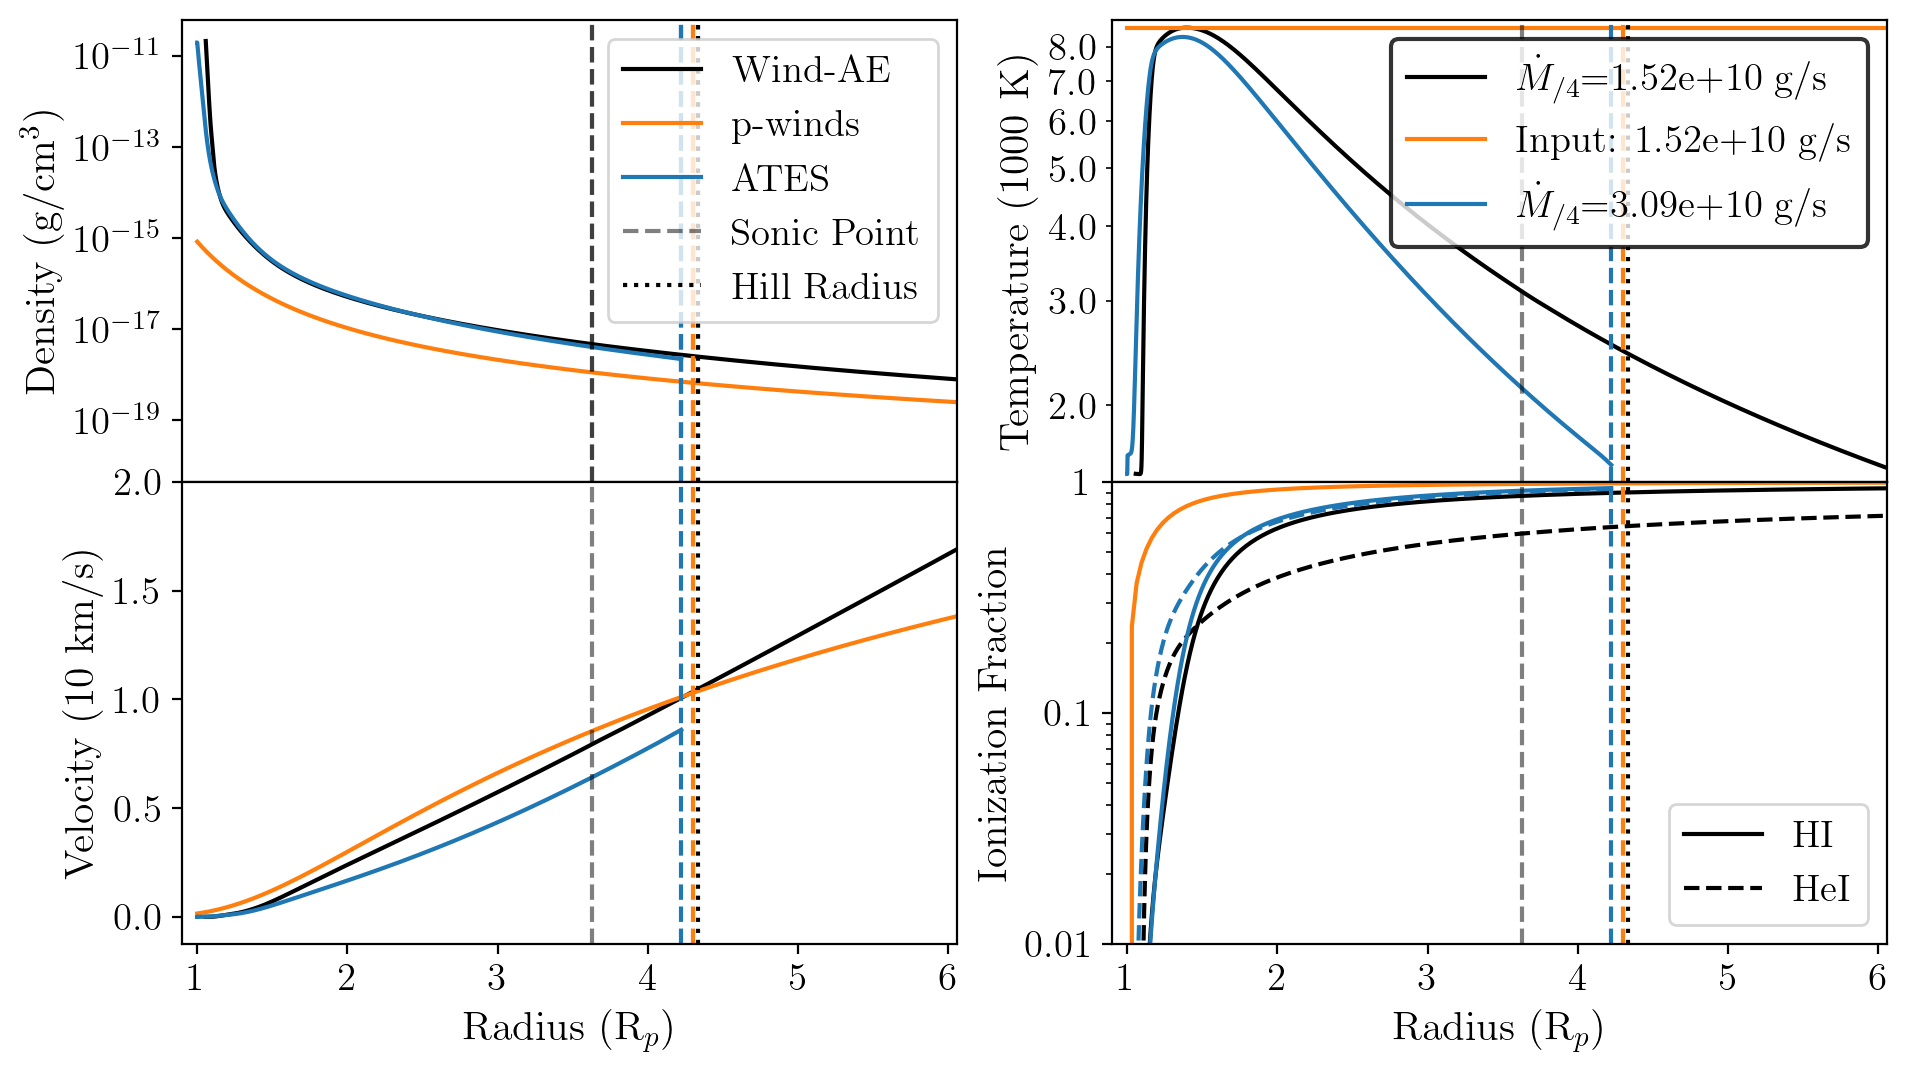

In [22]:
quick_plot(sim.windsoln,line_label='Wind-AE',fontsize=13)
plt.show()